In [ ]:
!git clone https://github.com/ThanhBinhisPissPhu/MovieRecSysWebMining.git

Cloning into 'MovieRecSysWebMining'...
remote: Enumerating objects: 325, done.
remote: Counting objects: 100% (325/325), done.
remote: Compressing objects: 100% (250/250), done.
remote: Total 325 (delta 115), reused 281 (delta 71), pack-reused 0 (from 0)
Receiving objects: 100% (325/325), 9.07 MiB | 4.99 MiB/s, done.
Resolving deltas: 100% (115/115), done.


In [ ]:
cd MovieRecSysWebMining

/content/MovieRecSysWebMining


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import nltk
from nltk.tokenize import RegexpTokenizer

In [ ]:
rating_column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df_ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=rating_column_names, engine='python')
df_ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
user_column_names = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
df_user = pd.read_csv('ml-100k/u.user', sep='|', names=user_column_names, engine='python')
df_user.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
movies_column_names = [
    'movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
    'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
    'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

# Load the dataset with proper handling
df_movie = pd.read_csv(
    'ml-100k/u.item', sep='|', engine='python',
    names=movies_column_names, encoding='ISO-8859-1', index_col=False
)

# Ensure index is properly set and inspect the structure
df_movie.reset_index(drop=True, inplace=True)

# Print results
df_movie.head()
# print(f"Number of columns in file: {df_movie.shape[1]}")

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
df_ratings = df_ratings.join(df_user.set_index('user_id'), on='user_id')
df_ratings = df_ratings.join(df_movie.set_index('movie_id'), on='item_id')

In [ ]:
df_ratings['rating'] = df_ratings['rating'].map(lambda x: 0 if x < 5 else 1)
df_ratings['gender'] = df_ratings['gender'].map(lambda x: 0 if x == 'F' else 1)

In [ ]:
zip_codes = list(set(df_ratings['zip_code']))
print("number of zip code: {}, number of users: {}".format(len(zip_codes), len(set(df_ratings['user_id']))))
zip_code2idx = {}
for idx, value in enumerate(zip_codes):
    zip_code2idx[value] = idx
df_ratings['zip_code'] = df_ratings['zip_code'].map(lambda x: zip_code2idx[x])

number of zip code: 795, number of users: 943


In [ ]:
# Preprocess year
titles = df_ratings['title']

years = [title[-5:-1] for title in titles]
year_set = list(set(years))
year_set.sort()
year2idx = {y: idx for idx, y in enumerate(year_set)}
years = [year2idx[y] for y in years]
df_ratings['year'] = years

In [ ]:
# Extract genre columns
genre_columns = [
    'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
    'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

# Create a genre-to-index mapping
genre2idx = {genre: idx + 1 for idx, genre in enumerate(genre_columns)}  # Start indexing from 1
print("Genre to Index Mapping:", genre2idx)

# Convert binary columns to lists of indices
res_genre = []
max_genre_len = 0

for _, row in df_ratings.iterrows():
    genres = [genre2idx[genre] for genre in genre_columns if row[genre] == 1]
    max_genre_len = max(max_genre_len, len(genres))
    res_genre.append(genres)

# Pad genres to have uniform length
for genre in res_genre:
    genre.extend([0] * (max_genre_len - len(genre)))

# Replace original genre columns with processed data
df_ratings['genres'] = res_genre

# Drop the original genre columns as they are no longer needed
df_ratings.drop(columns=genre_columns, inplace=True)

# Inspect the updated DataFrame
print(df_ratings.head())

Genre to Index Mapping: {'unknown': 1, 'Action': 2, 'Adventure': 3, 'Animation': 4, 'Childrens': 5, 'Comedy': 6, 'Crime': 7, 'Documentary': 8, 'Drama': 9, 'Fantasy': 10, 'Film-Noir': 11, 'Horror': 12, 'Musical': 13, 'Mystery': 14, 'Romance': 15, 'Sci-Fi': 16, 'Thriller': 17, 'War': 18, 'Western': 19}
   user_id  item_id  rating  timestamp  age  gender  occupation  zip_code  \
0      196      242       0  881250949   49       1      writer        65   
1      186      302       0  891717742   39       0   executive       346   
2       22      377       0  878887116   25       1      writer       232   
3      244       51       0  880606923   28       1  technician       471   
4      166      346       0  886397596   47       1    educator        86   

                        title release_date  video_release_date  \
0                Kolya (1996)  24-Jan-1997                 NaN   
1    L.A. Confidential (1997)  01-Jan-1997                 NaN   
2         Heavyweights (1994)  01-Jan

In [ ]:
# Preprocess titles
tokenizer = RegexpTokenizer(r'\w+')
titles = df_ratings['title']
tokenized_titles = []
titles = [tokenizer.tokenize(str(title[:-6])) for title in list(titles)]
vocab = []
max_title_len = 0
for title in titles:
    vocab += title
    max_title_len = max_title_len if max_title_len > len(title) else len(title)
vocab = set(vocab)
word2idx = {word: idx for idx, word in enumerate(vocab)}
res_title = []
for title in titles:
    padding_title = [word2idx[word] for word in title]
    padding_title.extend([0 for i in range(max_title_len - len(title))])
    res_title.append(padding_title)
df_ratings['title'] = res_title

In [ ]:
# Load u.occupation file
occupation_file = 'ml-100k/u.occupation'
occupation_mapping = {}
with open(occupation_file, 'r') as file:
    for idx, line in enumerate(file.readlines()):
        occupation_mapping[line.strip()] = idx + 1  # Map names to indices starting from 1

print("Occupation Mapping:", occupation_mapping)


Occupation Mapping: {'administrator': 1, 'artist': 2, 'doctor': 3, 'educator': 4, 'engineer': 5, 'entertainment': 6, 'executive': 7, 'healthcare': 8, 'homemaker': 9, 'lawyer': 10, 'librarian': 11, 'marketing': 12, 'none': 13, 'other': 14, 'programmer': 15, 'retired': 16, 'salesman': 17, 'scientist': 18, 'student': 19, 'technician': 20, 'writer': 21}


In [ ]:
# Map occupation names to indices
df_ratings['occupation'] = df_ratings['occupation'].map(occupation_mapping)

# Ensure the occupation column is now numeric
print(df_ratings['occupation'].head())

0    21
1     7
2    21
3    20
4     4
Name: occupation, dtype: int64


In [ ]:
# Reorder the columns
orders = ['user_id', 'gender', 'age', 'occupation', 'zip_code', 'item_id', 'year', 'title', 'genres', 'timestamp', 'rating']
df_ratings = df_ratings[orders]
description = [
    ('user_id', 1 + np.max(df_ratings['user_id']), 'spr'),
    ('gender', 1 + np.max(df_ratings['gender']), 'spr'),
    ('age', 1 + np.max(df_ratings['age']), 'spr'),
    ('occupation', 1 + np.max(df_ratings['occupation']), 'spr'),
    ('zip-code', 1 + np.max(df_ratings['zip_code']), 'spr'),
    ('item_id', 1 + np.max(df_ratings['item_id']), 'spr'),
    ('year', 1 + np.max(df_ratings['year']), 'spr'),
    ('title', 1 + np.max(list(df_ratings['title'])), 'seq'),
    ('genres', 1 + np.max(list(df_ratings['genres'])), 'seq'),
    ('time_stamp', -1, 'ctn'),
    ('rating', 2, 'label'),
    ('count', -1, 'ctn')
]
description

[('user_id', 944, 'spr'),
 ('gender', 2, 'spr'),
 ('age', 74, 'spr'),
 ('occupation', 22, 'spr'),
 ('zip-code', 795, 'spr'),
 ('item_id', 1683, 'spr'),
 ('year', 76, 'spr'),
 ('title', 2432, 'seq'),
 ('genres', 20, 'seq'),
 ('time_stamp', -1, 'ctn'),
 ('rating', 2, 'label'),
 ('count', -1, 'ctn')]

In [ ]:
# Preprocess timestamp
min_time_stamp = np.min(df_ratings['timestamp'])
max_time_stamp = np.max(df_ratings['timestamp'])

df_ratings['timestamp'] = df_ratings['timestamp'].map(lambda x: (x - min_time_stamp)/(max_time_stamp - min_time_stamp))
df_ratings = df_ratings.sort_values(by='timestamp')

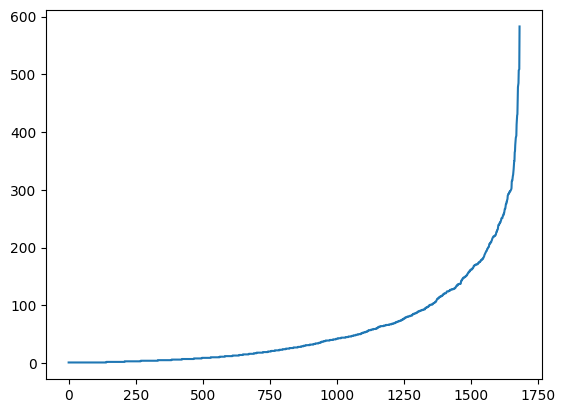

In [ ]:
# plot item counts vs item
user2count = df_ratings.groupby(['item_id']).size().reset_index(name='count').sort_values(by='count')
item_ids = list(user2count['item_id'])
counts = np.array(user2count['count'])
plt.plot(np.arange(len(counts)), counts)

In [ ]:
# Preprocess count
df_ratings = df_ratings.join(user2count.set_index('item_id'), on='item_id')
min_count = np.min(df_ratings['count'])
max_count = np.max(df_ratings['count'])
df_ratings['count'] = df_ratings['count'].map(lambda x: (x - min_count)/(max_count - min_count))

In [ ]:
df_ratings.head()

,user_id,gender,age,occupation,zip_code,item_id,year,title,genres,timestamp,rating,count
214,259,1,21,19,124,255,70,"[1388, 146, 571, 1332, 741, 0, 0, 0, 0, 0, 0, ...","[6, 15, 0, 0, 0, 0]",0.000000e+00,0,0.293814
83965,259,1,21,19,124,286,69,"[1181, 1362, 781, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[9, 15, 18, 0, 0, 0]",9.158531e-07,0,0.824742
43027,259,1,21,19,124,298,70,"[520, 231, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 16, 17, 0, 0, 0]",2.370443e-06,0,0.331615
21396,259,1,21,19,124,185,33,"[1604, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[12, 15, 17, 0, 0, 0]",3.825034e-06,0,0.408935
82655,259,1,21,19,124,173,60,"[982, 155, 781, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 3, 6, 15, 0, 0]",7.165204e-06,0,0.554983


In [ ]:
# Rename columns
df_ratings.rename(columns={'zip_code': 'zip-code', 'timestamp': 'time_stamp'}, inplace=True)

# Verify the changes
print(df_ratings.head())

       user_id  gender  age  occupation  zip-code  item_id  year  \
214        259       1   21          19       124      255    70   
83965      259       1   21          19       124      286    69   
43027      259       1   21          19       124      298    70   
21396      259       1   21          19       124      185    33   
82655      259       1   21          19       124      173    60   

                                                   title  \
214    [1388, 146, 571, 1332, 741, 0, 0, 0, 0, 0, 0, ...   
83965  [1181, 1362, 781, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
43027  [520, 231, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
21396   [1604, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
82655  [982, 155, 781, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                      genres    time_stamp  rating     count  
214      [6, 15, 0, 0, 0, 0]  0.000000e+00       0  0.293814  
83965   [9, 15, 18, 0, 0, 0]  9.158531e-07       0  0.824742  
43027   [2, 16, 17, 0, 0, 0]  2.370443e-0

In [ ]:
def split_2(df_ratings, description, N = 200, K = 20):
    user2count = df_ratings.groupby(['item_id']).size().reset_index(name='count').sort_values(by='count')
    item_ids = list(user2count['item_id'])
    counts = np.array(user2count['count'])

    item_ids, counts = np.asarray(item_ids), np.asarray(counts)
    hot_item_ids = item_ids[counts > N]
    cold_item_ids = item_ids[np.logical_and(counts <= N, counts >= 3 * K)]
    item_group = df_ratings.groupby('item_id')
    train_base = pd.DataFrame()
    for item_id in hot_item_ids:
        df_hot = item_group.get_group(item_id).sort_values(by='time_stamp')
        train_base = pd.concat([train_base, df_hot], ignore_index=True)
    train_warm_a, train_warm_b, train_warm_c, test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    for item_id in cold_item_ids:
        df_cold = item_group.get_group(item_id).sort_values(by='time_stamp')

        train_warm_a = pd.concat([train_warm_a, df_cold[:K]], ignore_index=True)
        train_warm_b = pd.concat([train_warm_b, df_cold[K:2*K]], ignore_index=True)
        train_warm_c = pd.concat([train_warm_c, df_cold[2*K:3*K]], ignore_index=True)
        test = pd.concat([test, df_cold[3*K:]], ignore_index=True)
    save_dic = {
        'train_base': train_base.sort_values('time_stamp'),
        'train_warm_a': train_warm_a.sort_values('time_stamp'),
        'train_warm_b': train_warm_b.sort_values('time_stamp'),
        'train_warm_c': train_warm_c.sort_values('time_stamp'),
        'test': test.sort_values('time_stamp'),
        'description': description
    }
    for name, df in save_dic.items():
        print("{} size: {}".format(name, len(df)))
    with open('./emb_warm_split_preprocess_ml-100K.pkl', 'bw+') as f:
        pickle.dump(save_dic, f)

In [ ]:
import random
random.seed(1)
split_2(df_ratings, description)

train_base size: 33480
train_warm_a size: 8380
train_warm_b size: 8380
train_warm_c size: 8380
test size: 21428
description size: 12


In [ ]:
# Get training data for Meta-Embedding method
with open('./emb_warm_split_preprocess_ml-100K.pkl', 'rb+') as f:
    data = pickle.load(f)
df_base = data['train_base']
item2group = df_base.groupby('item_id')
train_a, train_b, train_c, train_d = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for item_id, df_group in item2group:
    l, e = df_group.shape[0], df_group.shape[0] // 4

    train_a = pd.concat([train_a, df_group.iloc[0:e,]], ignore_index=True)
    train_b = pd.concat([train_b, df_group.iloc[e:2 * e,]], ignore_index=True)
    train_c = pd.concat([train_c, df_group.iloc[2 * e:3 * e,]], ignore_index=True)
    train_d = pd.concat([train_d, df_group.iloc[3 * e:4 * e,]], ignore_index=True)
shuffle_idx = np.random.permutation(train_a.shape[0])
train_a = train_a.iloc[shuffle_idx]
train_b = train_b.iloc[shuffle_idx]
train_c = train_c.iloc[shuffle_idx]
train_d = train_d.iloc[shuffle_idx]
data["metaE_a"] = train_a
data["metaE_b"] = train_b
data["metaE_c"] = train_c
data["metaE_d"] = train_d
with open('./movielens100K_data.pkl', 'wb+') as f:
    pickle.dump(data, f)

In [ ]:
import pickle

# Load the dictionary from the file
file_path = './movielens100K_data.pkl'

with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Print the loaded data (optional)
print(data['test'])

       user_id  gender  age  occupation  zip-code  item_id  year  \
17046      921       0   20          19       221       24    68   
17047      310       1   37           4       446       24    68   
17048      385       1   36          21       491       24    68   
17049       53       1   26          15        87       24    68   
17050      804       1   39           4       249       24    68   
...        ...     ...  ...         ...       ...      ...   ...   
13294      683       1   42          11       742      472    69   
13494      683       1   42          11       742      248    70   
515        729       1   19          19       761      354    71   
21148      729       1   19          19       761      272    70   
1899       729       1   19          19       761      689    70   

                                                   title               genres  \
17046  [2387, 722, 350, 1548, 0, 0, 0, 0, 0, 0, 0, 0,...   [2, 3, 7, 0, 0, 0]   
17047  [2387, 722, 35

In [ ]:
test = data['test']

In [ ]:
test_sorted = test.sort_values(by='item_id')

# Group by 'item_id'
grouped_test = test.groupby('item_id')
print(grouped_test.head())

       user_id  gender  age  occupation  zip-code  item_id  year  \
17046      921       0   20          19       221       24    68   
17047      310       1   37           4       446       24    68   
17048      385       1   36          21       491       24    68   
17049       53       1   26          15        87       24    68   
17050      804       1   39           4       249       24    68   
...        ...     ...  ...         ...       ...      ...   ...   
120        189       1   32           2       283      855    54   
31         189       1   32           2       283       60    66   
43         189       1   32           2       283      486    27   
162        189       1   32           2       283      607    13   
71         683       1   42          11       742      887    70   

                                                   title  \
17046  [2387, 722, 350, 1548, 0, 0, 0, 0, 0, 0, 0, 0,...   
17047  [2387, 722, 350, 1548, 0, 0, 0, 0, 0, 0, 0, 0,...   
170

In [ ]:
print(test['rating'].tolist())

[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 

In [ ]:
import pandas as pd

# Group by 'user_id' and count the total number of items rated
user_rating_stats = test.groupby('user_id').agg(
    item_count=('item_id', 'nunique'),  # Count unique items rated
    rating_1_count=('rating', lambda x: (x == 1).sum()),  # Count items rated 1
    rating_0_count=('rating', lambda x: (x == 0).sum())   # Count items rated 0
)

# Reset the index to convert the result into a DataFrame
user_rating_stats = user_rating_stats.reset_index()

# Display the result
print(user_rating_stats)

# Optional: Summary statistics
print("\nSummary Statistics:")
print(user_rating_stats.describe())

     user_id  item_count  rating_1_count  rating_0_count
0          1           7               4               3
1          2          25               4              21
2          3          19               4              15
3          4           8               4               4
4          6          66              14              52
..       ...         ...             ...             ...
738      938          54               7              47
739      939          10               8               2
740      940          37               2              35
741      942          33              14              19
742      943          56              10              46

[743 rows x 4 columns]

Summary Statistics:
          user_id  item_count  rating_1_count  rating_0_count
count  743.000000  743.000000      743.000000      743.000000
mean   468.596231   28.839838        5.960969       22.878869
std    271.301984   34.568771        9.577170       28.670850
min      1.000000    1.

In [ ]:
df_ratings

,user_id,gender,age,occupation,zip-code,item_id,year,title,genres,time_stamp,rating,count
214,259,1,21,19,75,255,70,"[84, 1241, 275, 1843, 2017, 0, 0, 0, 0, 0, 0, ...","[6, 15, 0, 0, 0, 0]",0.000000e+00,0,0.293814
83965,259,1,21,19,75,286,69,"[221, 129, 1117, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[9, 15, 18, 0, 0, 0]",9.158531e-07,0,0.824742
43027,259,1,21,19,75,298,70,"[54, 2327, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 16, 17, 0, 0, 0]",2.370443e-06,0,0.331615
21396,259,1,21,19,75,185,33,"[1427, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[12, 15, 17, 0, 0, 0]",3.825034e-06,0,0.408935
82655,259,1,21,19,75,173,60,"[2372, 1768, 1117, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 3, 6, 15, 0, 0]",7.165204e-06,0,0.554983
...,...,...,...,...,...,...,...,...,...,...,...,...
46773,729,1,19,19,142,689,70,"[328, 1117, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[2, 17, 0, 0, 0, 0]",1.000000e+00,0,0.147766
73008,729,1,19,19,142,313,70,"[2399, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 9, 15, 0, 0, 0]",1.000000e+00,0,0.599656
46574,729,1,19,19,142,328,70,"[28, 1839, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 14, 15, 17, 0, 0]",1.000000e+00,0,0.505155
64312,729,1,19,19,142,748,70,"[2193, 1117, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 15, 17, 0, 0, 0]",1.000000e+00,0,0.541237


In [ ]:
# Step 1: Filter rows where rating is 1
rating_1_df = df_ratings[df_ratings['rating'] == 1]

# Step 2: Group by user_id and count the number of items each user rated as 1
user_item_counts = rating_1_df.groupby('user_id')['item_id'].count()

# Step 3: Calculate statistics
total_users = user_item_counts.count()  # Total number of users who rated at least one item as 1
mean_items = user_item_counts.mean()   # Average number of items rated as 1 per user
median_items = user_item_counts.median()  # Median number of items rated as 1 per user
min_items = user_item_counts.min()  # Minimum number of items rated as 1 per user
max_items = user_item_counts.max()  # Maximum number of items rated as 1 per user

# Output results
print(f"Total users who rated at least one item as 1: {total_users}")
print(f"Mean number of items rated as 1 per user: {mean_items}")
print(f"Median number of items rated as 1 per user: {median_items}")
print(f"Minimum number of items rated as 1 by a user: {min_items}")
print(f"Maximum number of items rated as 1 by a user: {max_items}")

Total users who rated at least one item as 1: 928
Mean number of items rated as 1 per user: 22.845905172413794
Median number of items rated as 1 per user: 14.0
Minimum number of items rated as 1 by a user: 1
Maximum number of items rated as 1 by a user: 172


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

source_path = '/content/MovieRecSysWebMining/movielens100K_data.pkl'
destination_path = '/content/drive/MyDrive/movielens100K_data.pkl'

# Move the file to Google Drive
shutil.move(source_path, destination_path)

print(f"File moved to {destination_path}")

File moved to /content/drive/MyDrive/movielens100K_data.pkl
